In [1]:
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from data_preparation.preprocessing.outlier_handler import OutlierHandler
from data_preparation.splitting.data_splitter import DataSplitter
from data_preparation.resampling.resampler import Resampler

In [2]:
DATA_DIR = Path("../data")
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
FINAL_DATA_DIR = DATA_DIR / "final"

In [3]:
file = open(PROCESSED_DATA_DIR / "creditcard_processed.csv", "r", encoding="utf-8")
cols = {}

first_line = file.readline().strip().split(",")
for col_name in first_line:
    cols[col_name] = []

for line in file:
    values = line.strip().split(",")
    for i, value in enumerate(values):
        cols[first_line[i]].append(float(value))

for col in cols:
    cols[col] = np.array(cols[col])

file.close()

# 1. Khảo sát lại dữ liệu 

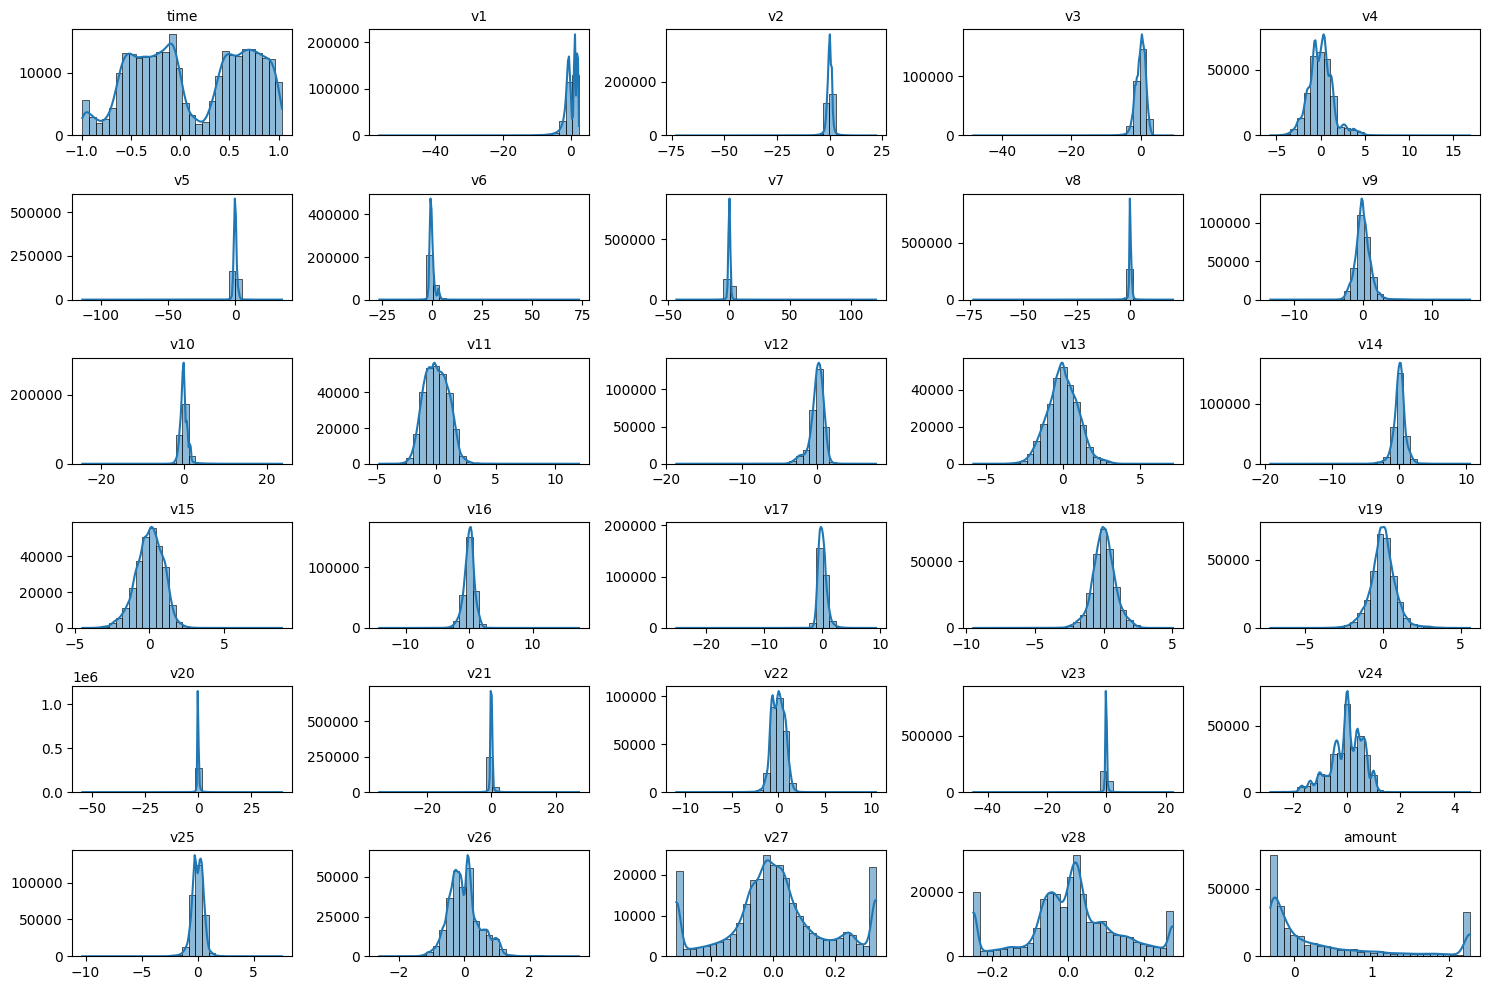

In [4]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(cols):
    if col == "class":
        continue
    plt.subplot(6, 5, i + 1)
    sns.histplot(cols[col], bins=30, kde=True)
    plt.title(f"{col}", fontsize=10)
    plt.xlabel("", fontsize=8)
    plt.ylabel("", fontsize=8)

plt.tight_layout()
plt.show()

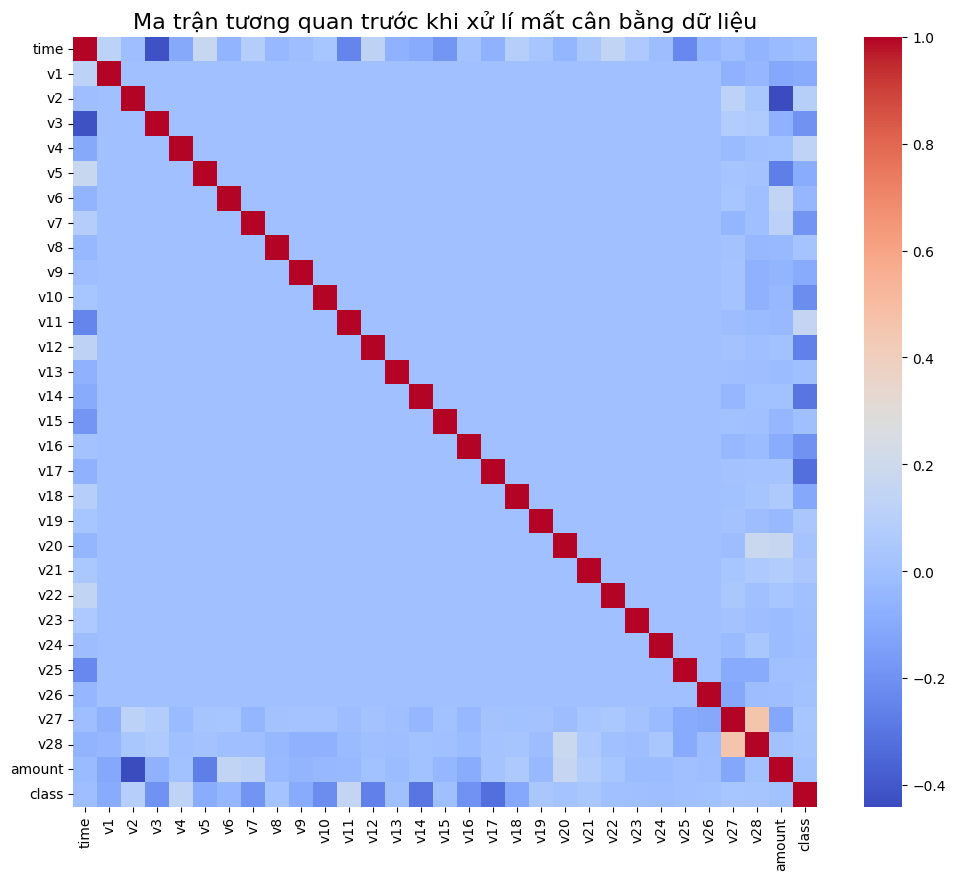

In [5]:
# ma trận tương quan

corr_matrix = np.corrcoef([cols[col] for col in cols])
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    xticklabels=list(cols.keys()),
    yticklabels=list(cols.keys()),
    cmap="coolwarm",
    annot=False,
)
plt.title("Ma trận tương quan trước khi xử lí mất cân bằng dữ liệu", fontsize=16)
plt.show()

## Nhận xét
- Mặc dù dữ liệu vẫn còn tồn tại một số giá trị ngoại lai, nhưng số lượng các giá trị này đã được giảm đáng kể sau quá trình xử lý.
- Tuy nhiên, mức độ tương quan giữa các tham số vẫn còn khá thấp, chủ yếu do sự mất cân bằng giữa các lớp dữ liệu. Vì vậy, chúng ta cần áp dụng các phương pháp Resampling để giải quyết vấn đề này trong các bước tiếp theo.

# 2. Resampling

### Động lực của kĩ thuật Resampling

- Chính vì sự mất cân bằng dữ liệu của 2 lớp có thể gây ra hiện tượng under-fitting của mô hình.
- Gần như toàn bộ tham số của mô hình sẽ bị chi phối bởi class chiếm đa số.
- Tỷ lệ mất cân bằng quá lớn (~0.998 so với ~0.001) làm cho các thang đonhư Recall, Precision, F1-score của lớp thiểu số giảm mạnh và kết quả đánh giá trở nên không phản ánh đúng hiệu năng thực tế.

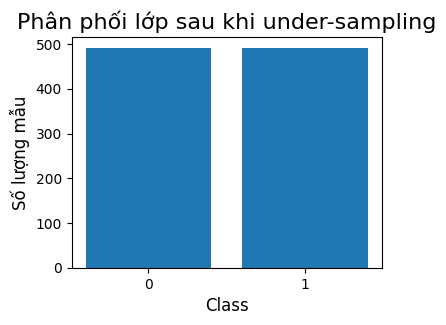

In [6]:
X = np.array([cols[col] for col in cols if col != "class"]).T
y = cols["class"]

under_sample_target = len(y[y == 1])

(under_sampled_X, under_sampled_y) = Resampler.under_sample(
    X=X,
    y=y,
    target_size=under_sample_target,
)

plt.figure(figsize=(4, 3))
plt.title("Phân phối lớp sau khi under-sampling", fontsize=16)
plt.bar(
    ["0", "1"],
    [
        len(under_sampled_y[under_sampled_y == 0]),
        len(under_sampled_y[under_sampled_y == 1]),
    ],
)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Số lượng mẫu", fontsize=12)
plt.show()

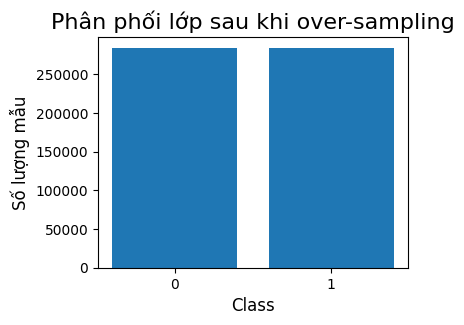

In [7]:
over_sample_target = len(y[y == 0])
(over_sampled_X, over_sampled_y) = Resampler.over_sample(
    X=X,
    y=y,
    target_size=over_sample_target,
)
plt.figure(figsize=(4, 3))
plt.title("Phân phối lớp sau khi over-sampling", fontsize=16)
plt.bar(
    ["0", "1"],
    [
        len(over_sampled_y[over_sampled_y == 0]),
        len(over_sampled_y[over_sampled_y == 1]),
    ],
)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Số lượng mẫu", fontsize=12)
plt.show()

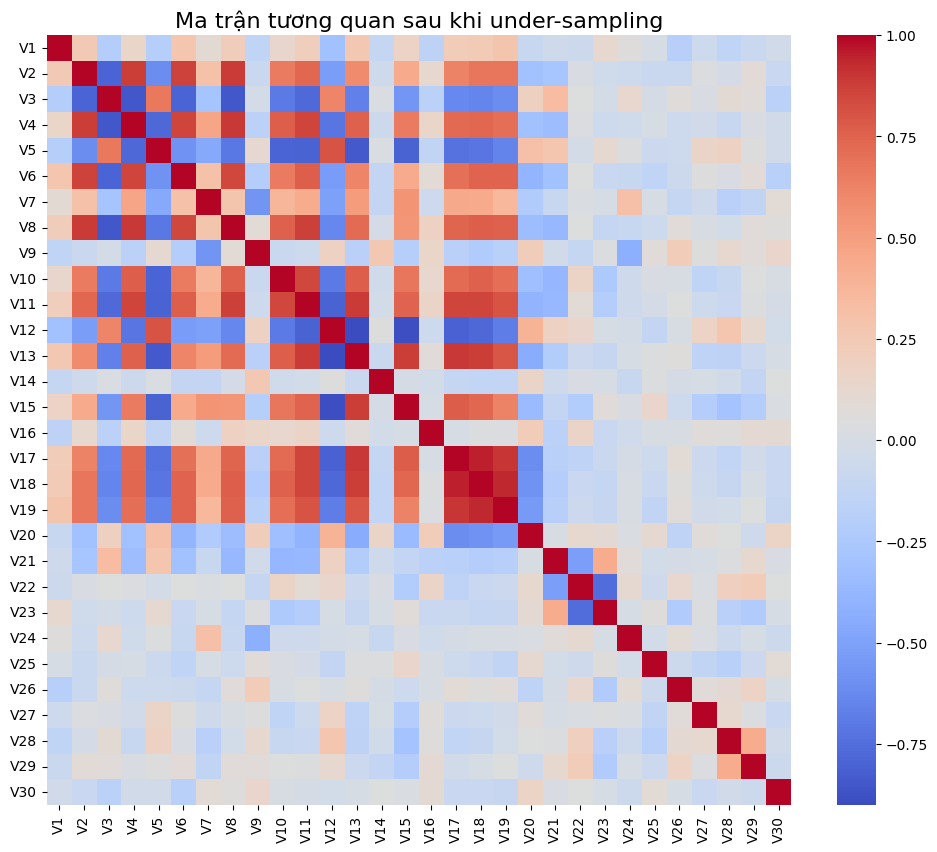

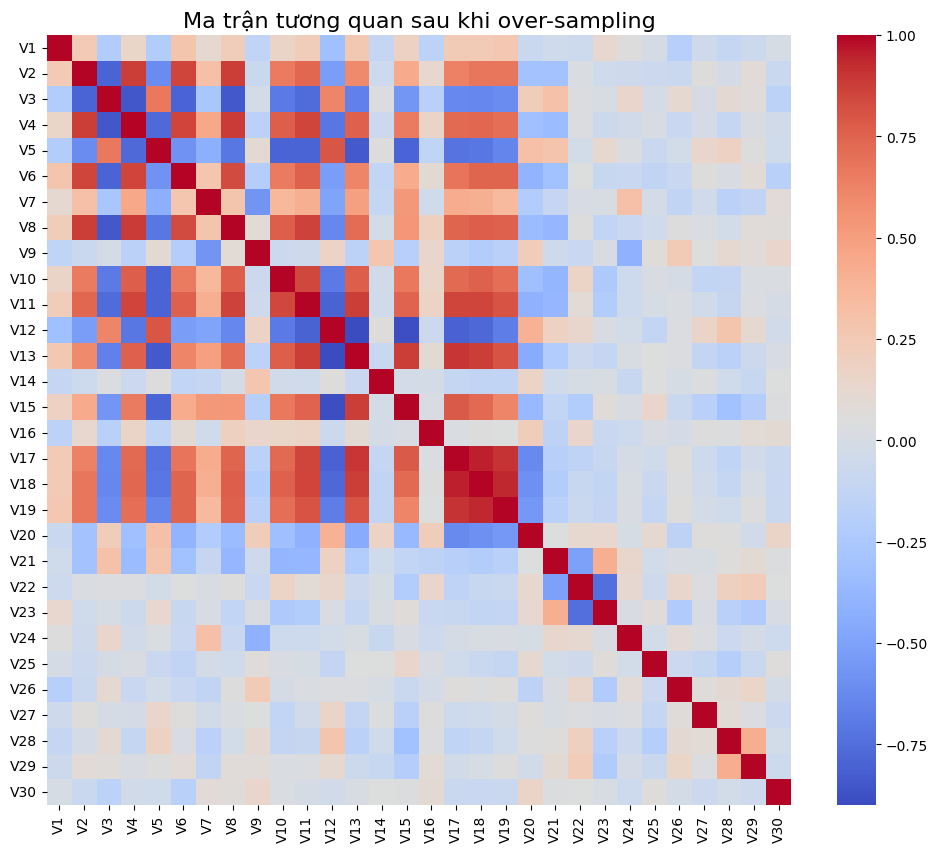

In [8]:
# vẽ 2 cái ma trận tương quan sau khi undersampling và oversampling

corr_matrix_under = np.corrcoef(
    [under_sampled_X[:, i] for i in range(under_sampled_X.shape[1])]
)
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix_under,
    xticklabels=[f"V{i+1}" for i in range(under_sampled_X.shape[1])],
    yticklabels=[f"V{i+1}" for i in range(under_sampled_X.shape[1])],
    cmap="coolwarm",
    annot=False,
)
plt.title("Ma trận tương quan sau khi under-sampling", fontsize=16)
plt.show()

corr_matrix_over = np.corrcoef(
    [over_sampled_X[:, i] for i in range(over_sampled_X.shape[1])]
)
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix_over,
    xticklabels=[f"V{i+1}" for i in range(over_sampled_X.shape[1])],
    yticklabels=[f"V{i+1}" for i in range(over_sampled_X.shape[1])],
    cmap="coolwarm",
    annot=False,
)
plt.title("Ma trận tương quan sau khi over-sampling", fontsize=16)
plt.show()

### Nhận xét
- Sau khi thực hiện một trong hai phương pháp Resampling, ta có thể thấy rằng sự tương quan giữa các cột được làm rõ hơn, cũng như ta có được sự cân bằng dữ liệu giữa hai lớp.
- Tuy nhiên, việc sử dụng kĩ thuật Resampling cũng có những mặt trái của nó:
    - Over-sampling: gây ra hiện tượng trùng lắp dữ liệu, đặc biệt với dữ liệu này khi mà class 0 chiếm tận 99.8%, trong khi class 1 chỉ chiếm một phần rất nhỏ (gần như không đáng kể), dễ gây ra hiện tượng overfitting.
    - Under-sampling: ngược lại với over-sampling, under-sampling lại có nguy cơ khiến cho mô hình bị bỏ qua các dữ liệu quan trọng, bởi việc bỏ quá nhiều mẫu chiếm đa số.

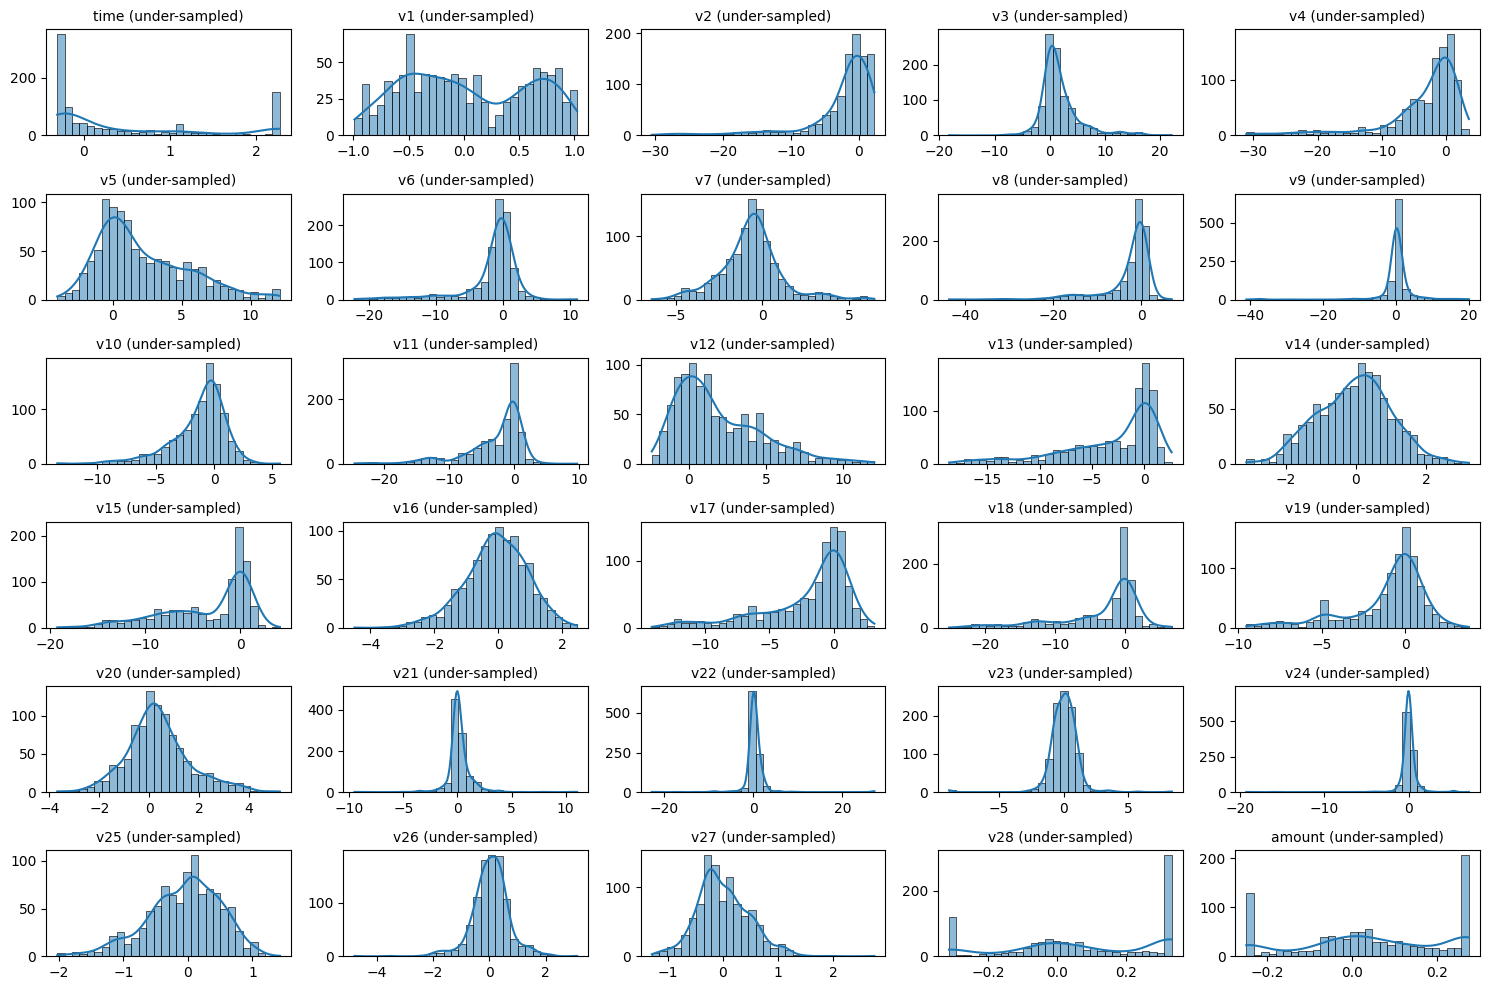

In [9]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(cols):
    if col == "class":
        continue
    plt.subplot(6, 5, i + 1)
    sns.histplot(under_sampled_X[:, i - 1], bins=30, kde=True)
    plt.title(f"{col} (under-sampled)", fontsize=10)
    plt.xlabel("", fontsize=8)
    plt.ylabel("", fontsize=8)
plt.tight_layout()
plt.show()

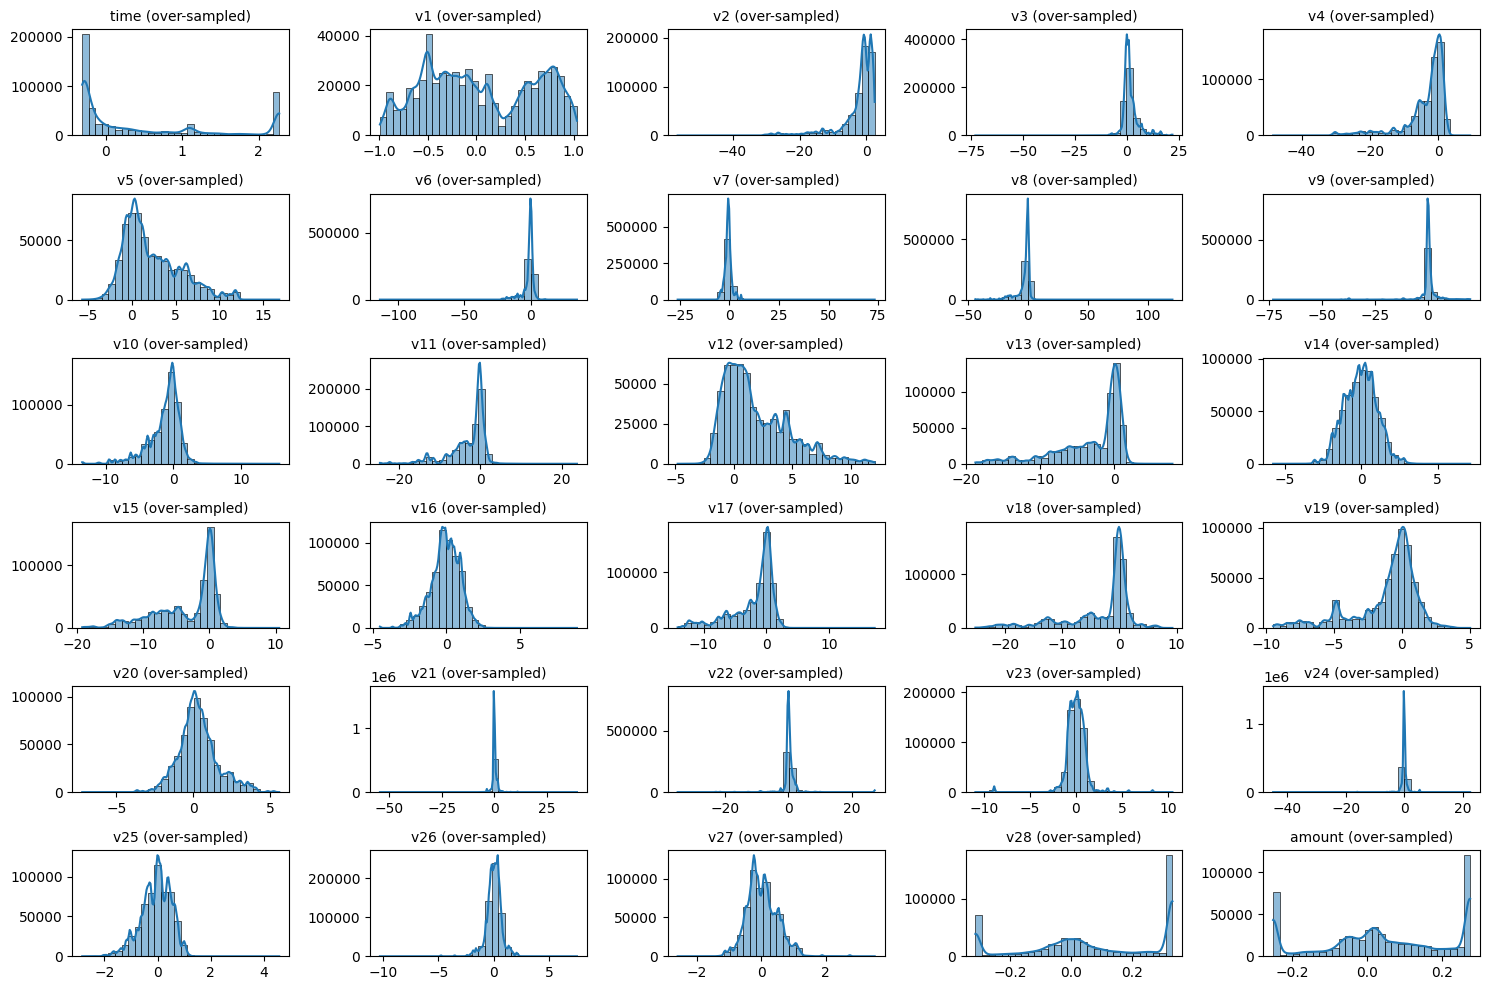

In [10]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(cols):
    if col == "class":
        continue
    plt.subplot(6, 5, i + 1)
    sns.histplot(over_sampled_X[:, i - 1], bins=30, kde=True)
    plt.title(f"{col} (over-sampled)", fontsize=10)
    plt.xlabel("", fontsize=8)
    plt.ylabel("", fontsize=8)
plt.tight_layout()
plt.show()

### Nhận xét
- Phân phối của giá trị của các cột có sự thay đổi đáng kể.

# 3. Chia và lưu các tập dữ liệu cho mô hình

In [11]:
train_size = 0.7
test_size = 0.3

## 3.1 Dữ liệu gốc (mất cân bằng)

In [12]:
DataSplitter.save_split_data(
    X=X,
    y=y,
    train_size=train_size,
    test_size=test_size,
    output_dir=FINAL_DATA_DIR / "original",
    random_seed=42,
)

Data saved to ../data/final/original


## 3.2 Dữ liệu under-sampling 

In [13]:
DataSplitter.save_split_data(
    X=under_sampled_X,
    y=under_sampled_y,
    train_size=train_size,
    test_size=test_size,
    output_dir=FINAL_DATA_DIR / "under_sampled",
    random_seed=42,
)

Data saved to ../data/final/under_sampled


## 3.3 Dữ liệu over-sampling

In [14]:
DataSplitter.save_split_data(
    X=over_sampled_X,
    y=over_sampled_y,
    train_size=train_size,
    test_size=test_size,
    output_dir=FINAL_DATA_DIR / "over_sampled",
    random_seed=42,
)

Data saved to ../data/final/over_sampled
